# Predicting defaulting on credit card applications

When customers come in financial difficulties, it usually does not happen at once. There are indicators which can be used to anticipate the final outcome, such as late payments, calls to the customer services, enquiries about the products, a different browsing pattern on the web or mobile app. By using such patterns it is possible to prevent, or at least guide the process and provide a better service for the customer as well as reduced risks for the bank.

In this tutorial we will look at how to predict defaulting, using statistics, machine learning and deep learning. We we also look at how to summarize the data using topological data analysis (TDA). Finally we will look at how to APIfy the model and use it for account alerting.

#### Imports

In [1]:

#data explore
import numpy as np

# dataframes in python
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

#### Data preparation
I read the data from the raw csv which is the competition dataset

In [29]:
model_sample = pd.read_csv("./data/model_sample.csv") #this data is to train the model
verify_sample= pd.read_csv("./data/verify_sample.csv") #this data is test data


In [30]:
model_sample.tail()

,user_id,y,x_001,x_002,x_003,x_004,x_005,x_006,x_007,x_008,...,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199
10013,A21934,0,0.0,29.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,A21936,1,0.0,25.0,0,0,0,0,0,0,...,3.0,3.0,3.0,3.0,5.0,5.0,4.0,4.0,7.0,7.0
10015,A21938,0,0.0,28.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10016,A21940,0,0.0,23.0,0,0,0,0,0,0,...,1.0,0.0,3.0,1.0,5.0,1.0,3.0,1.0,7.0,1.0
10017,A21941,1,0.0,35.0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### process missing value

the code is here([missing_data_process](./missing_data_process.ipynb))

### Read the processed data
from csv file(model_sample_nomissing.csv)

In [3]:
clean_data = pd.read_csv('model_sample_nomissing.csv',index_col=0)

In [4]:
clean_data.tail()

,y,x_001,x_002,x_003,x_004,x_005,x_006,x_007,x_008,x_009,...,x_190,x_191,x_192,x_193,x_194,x_195,x_196,x_197,x_198,x_199
10013,0,0.0,29.0,0,0,0,0,0,0,0,...,0.0,0.0,2.0,2.0,3.0,2.0,4.0,4.0,6.0,6.0
10014,1,0.0,25.0,0,0,0,0,0,0,0,...,3.0,3.0,3.0,3.0,5.0,5.0,4.0,4.0,7.0,7.0
10015,0,0.0,28.0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10016,0,0.0,23.0,0,0,0,0,0,0,0,...,1.0,0.0,3.0,1.0,5.0,1.0,3.0,1.0,7.0,1.0
10017,1,0.0,35.0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
columns_name = clean_data.columns

### Feature engineering

It's not about blind feature conversion to values between 0 and 1, it's about understanding data. In this case we see that money they exibits a log distribution, so first off, I am going to take the log of the money.

In [6]:
# help func
# select those need log
def selcols():
    colnames = []
    colnames.extend(['x_041','x_043','x_044','x_045','x_046','x_047'])
    colnames.extend(['x_052','x_053','x_054','x_055','x_057','x_058','x_059'])
    colnames.extend(['x_060','x_061','x_064','x_067'])
    colnames.extend(['x_070','x_073','x_078','x_079'])
    colnames.extend(['x_080','x_085','x_086','x_087'])
    colnames.extend(['x_108','x_111','x_114','x_117','x_120','x_125','x_126','x_127'])
    colnames.extend(['x_130','x_131','x_133','x_135','x_136','x_138'])
    colnames.extend(['x_140','x_141','x_143','x_145','x_146','x_147','x_148'])
    colnames.extend(['x_159','x_160','x_161','x_172','x_173','x_174'])
    colnames.extend(['x_185','x_186','x_187'])
    return colnames

In [7]:
# generate the new dataset by log
colindex = selcols()
for col in colindex:
    if col in columns_name:
        clean_data[col] = clean_data[col].apply(lambda x: np.log(x+1) if x>0 else 0) 
        #verify_sample[col] = verify_sample[col].apply(lambda x: np.log(x+1) if x>0 else 0)

### Seperate the labels and input variables

In [8]:
y = clean_data.iloc[:, 0]
X = clean_data.iloc[:,1:]
#verify_X = verify_sample.iloc[:,1:]

### Feature scaling
* MinMaxScaler
* StandardScaler N(0,1)
* RobustScaler avoid outliers.


In [9]:
# three diffrent methods
#- MinMaxScaler
#- StandardScaler N(0,1)
#- RobustScaler avoid outliers.

#- X_test's standardization should use the mean and std of X_train

def MinMaxNorm(X_train,X_test):
    from sklearn.preprocessing import MinMaxScaler

    mms = MinMaxScaler().fit(X_train)
    X_train_norm = mms.transform(X_train)
    X_test_norm = mms.transform(X_test)
    return X_train_norm,X_test_norm

def StdNorm(X_train,X_test):
    from sklearn.preprocessing import StandardScaler

    stdsc = StandardScaler().fit(X_train)
    X_train_std = stdsc.transform(X_train)
    X_test_std = stdsc.transform(X_test)
    return X_train_std,X_test_std

def RobustNorm(X_train,X_test):
    from sklearn.preprocessing import RobustScaler

    rbs = RobustScaler().fit(X_train)
    X_train_std = rbs.transform(X_train)
    X_test_std = rbs.transform(X_test)
    return X_train_std,X_test_std


In [18]:
# here you should notice that the X_test's standardization should use the train data's method
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = RobustNorm(X_train, X_test)
#X_train = X_prep
#y_train = y

### Whether data label is balanced or not? 
#### Explore Defaulting

First off, let's start with a zoomed out view on the problem.  
We want to predict defaulting, Let's answer the following question:

  - how many cases do we have on our dataset to work with? 

We can see that the data labels are imbalaned.
defaulting accounts are 19% and no-defaulting accounts are 81%

defaulting accounts are 19% out of 10018 observations


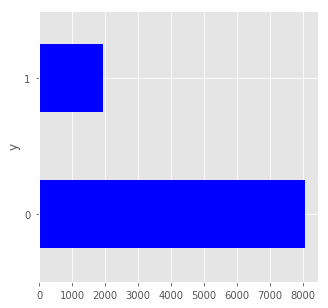

In [11]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = clean_data.groupby(['y']).size()

print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='blue')

### Resampling
* RandomOverSampler
    * Object to over-sample the minority class(es) by picking samples at random with replacement.
* SMOTE
    * SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.
    
    Learn more about SMOTE, see the original 2002 paper titled ["SMOTE: Synthetic Minority Over-sampling Technique"](https://jair.org/index.php/jair/article/view/10302).
* ADASYN
    * [Perform over-sampling using Adaptive Synthetic Sampling Approach for Imbalanced Learning](http://140.123.102.14:8080/reportSys/file/paper/manto/manto_6_paper.pdf)

* SMOTETomek
    * Class to perform over-sampling using SMOTE and cleaning using Tomek links.Combine over- and under-sampling using SMOTE and Tomek links.
* SMOTEENN
    * Class to perform over-sampling using SMOTE and cleaning using ENN.Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.
    
    
You can also check these methods from python [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/applications/plot_topic_classication.html) package


In [17]:
# Resampling functions
from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE
from imblearn.combine import SMOTETomek,SMOTEENN

# Apply RandomOverSampler
def my_RandomOverSampler(X_train,y_train):
    sm = RandomOverSampler()
    X_resampled, y_resampled = sm.fit_sample(X_train, y_train)
    return X_resampled, y_resampled

# Apply SMOTE
def my_SMOTE(X_train,y_train):
    sm = SMOTE()
    X_resampled, y_resampled = sm.fit_sample(X_train, y_train)
    return X_resampled, y_resampled

# Apply ADASYN
def my_ADASYN(X_train,y_train):
    sm = ADASYN()
    X_resampled, y_resampled = sm.fit_sample(X_train, y_train)
    return X_resampled, y_resampled

# Apply SMOTE + Tomek links
def my_SMOTETomek(X_train,y_train):
    sm = SMOTETomek()
    X_resampled, y_resampled = sm.fit_sample(X_train, y_train)
    return X_resampled, y_resampled

# Apply SMOTE + ENN
def my_SMOTEENN(X_train,y_train):
    sm = SMOTEENN()
    X_resampled, y_resampled = sm.fit_sample(X, y)
    return X_resampled, y_resampled

In [25]:
X_resample,y_resample = my_SMOTEENN(X_train,y_train)

##### train dataset is increased through resampling

In [28]:
print(len(X_resample),len(X_train))

(11714, 8014)


#### Feature selection
* Too many features may cause overfitting
* Here we reduce the features by assessing feature importance with random forests
* Also,There are no need to reduce the features for some machine learning method. We can apply other method to control overfitting.eg. dropout for DNN

 1) x_142                          0.040847
 2) x_056                          0.038740
 3) x_191                          0.034667
 4) x_122                          0.033473
 5) x_190                          0.029487
 6) x_188                          0.029354
 7) x_189                          0.028788
 8) x_042                          0.027681
 9) x_192                          0.026253
10) x_075                          0.026155
11) x_144                          0.025139
12) x_139                          0.024176
13) x_193                          0.022522
14) x_195                          0.022082
15) x_132                          0.020932
16) x_194                          0.020285
17) x_127                          0.018444
18) x_137                          0.017611
19) x_134                          0.017454
20) x_125                          0.016868
21) x_078                          0.016417
22) x_059                          0.015738
23) x_045                       

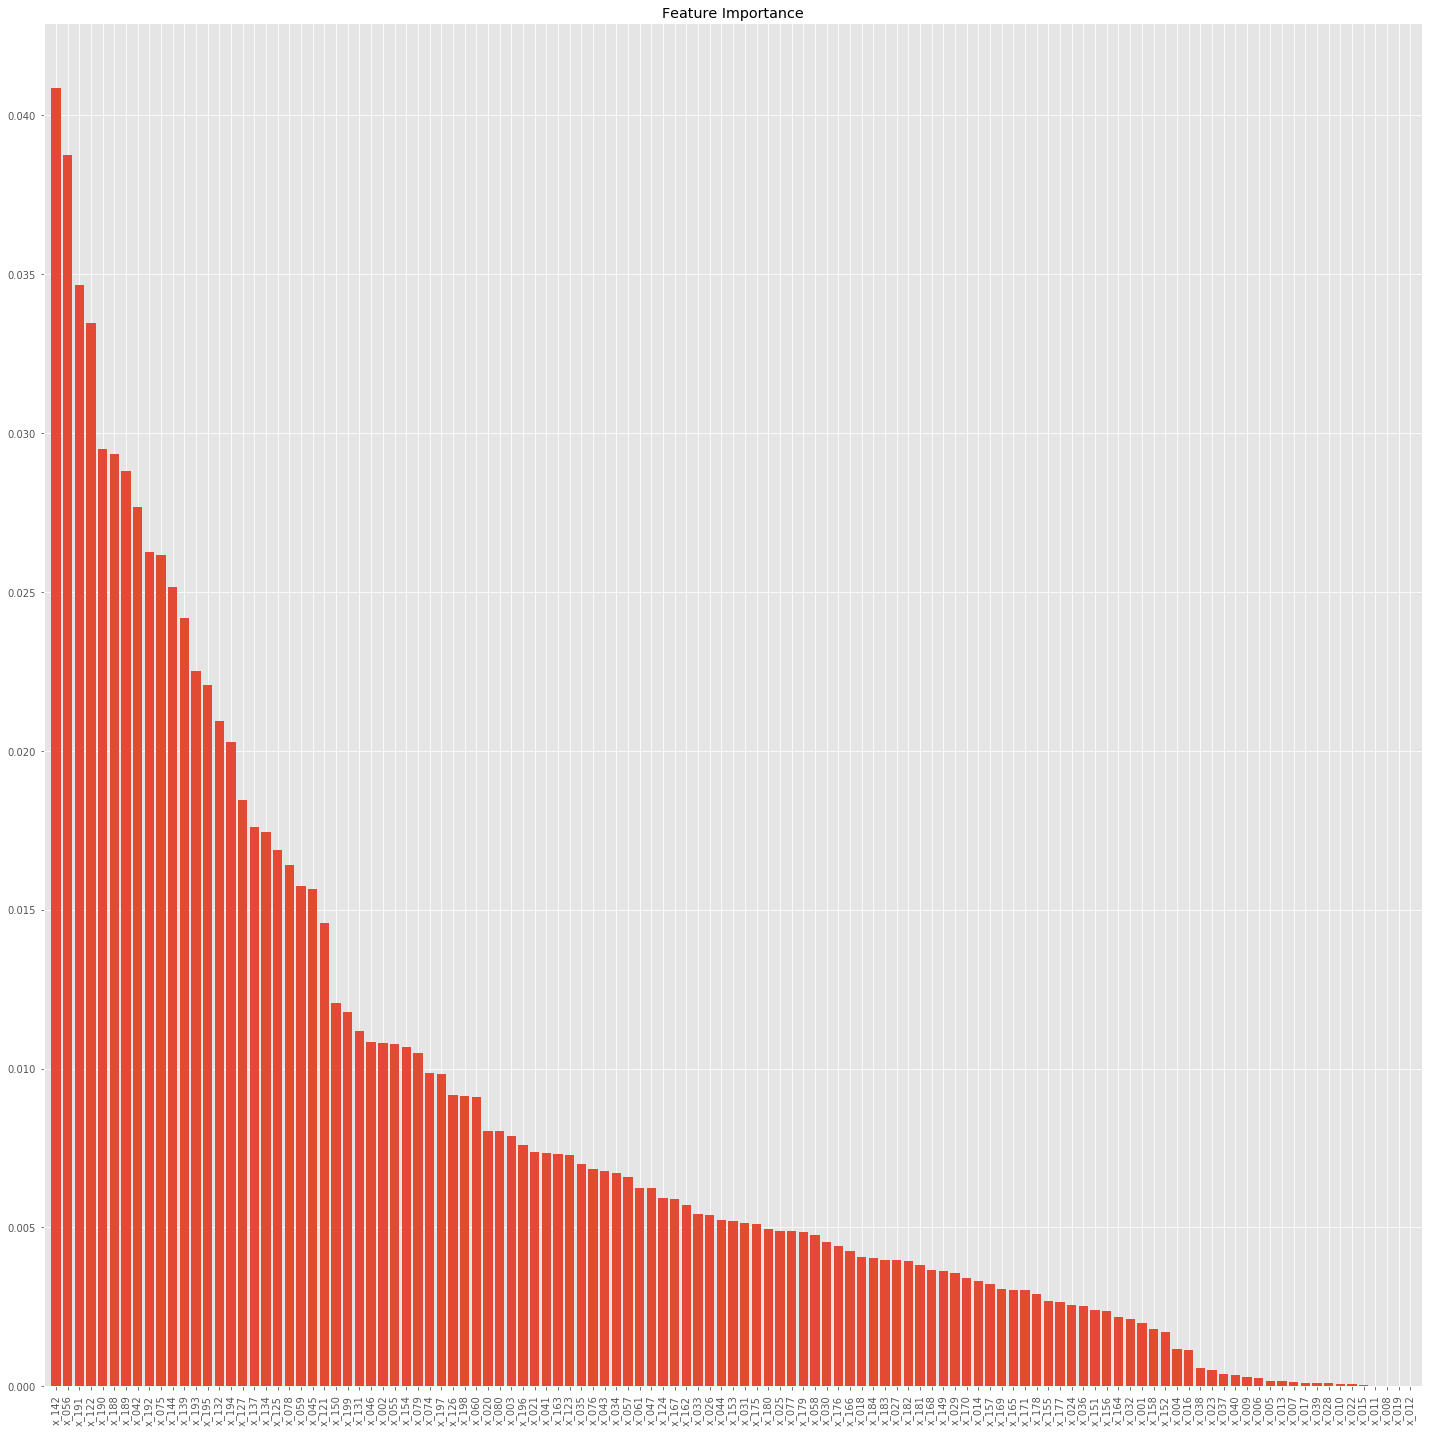

In [30]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = clean_data.columns[1:]

forest = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,
                                max_features = 'log2',n_jobs=4,criterion='gini')

forest.fit(X_resample, y_resample)
importances = forest.feature_importances_



indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_resample.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_resample.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_resample.shape[1]])
plt.tight_layout()
plt.savefig('/features_selection.png', dpi=300)
plt.show()


## Models
* Logistic regression
* SVM
* RandomForest
    * RandomForestClassifier
    * GradientBoostingClassifier
* Deep Neural Network

### Model valuation
* Visualization: Confusion matrices and AUC curves
* f1 score

In [65]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix,f1_score

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    ax.legend([train_text, test_text])
def result_analyse(est,threshold,X_train,X_test,y_train,y_test):
    y_train_pred = est.predict_proba(X_train)[:,1]
    y_test_pred = est.predict_proba(X_test)[:,1]


    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)

    plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
    plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
    plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
    plt.tight_layout()
    plt.show()



### F1 score 
* this value is required by the competition, teams are ranked by F1 score
* F1 score is sensitive to the threshold of probability, so, here I define a function to select relative best threshold to serve as the threshold test data
    *  I will select the average threshold which 5 continue f1 score is maximum

In [58]:
from sklearn.metrics import accuracy_score,f1_score
#est learning estimator
def best_threshold_f1_score(est,X_test,y_test):
    thresholds = np.linspace(0.2,0.8,200)
    y_test_pred = est.predict_proba(X_test)[:,1]
    score_set = []
    index_threshold = 0
    sum_score = 0
    for threshold in thresholds:
        y_test_pred1  = (y_test_pred > threshold).astype(int)
        score = f1_score(y_test, y_test_pred1)
        score_set.append(score)
    for i in range(195):
        temp = sum(score_set[i:i+5])
        if temp > sum_score:
            sum_score = temp
            index_threshold = i+2 # the average threshold
    
    return thresholds[index_threshold],sum_score/5

def test_f1_score(est,best_threshold,X_test,y_test):
    y_test_pred = regr.predict_proba(X_test)[:,1]
    y_test_pred1  = (y_test_pred > best_threshold).astype(int)
    score = f1_score(y_test, y_test_pred1)
    return score
    

#### Logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression
# Create logistic regression object
regr = LogisticRegression(penalty='l2', C=10.**2, random_state=0)

# Train the model using the training sets
regr.fit(X_resample, y_resample)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Result Analyse
* train and test f1 score
* train and test confusion matrix
* ROC curve

('test f1 score:', 0.46973012399708236, 'train f1 score:', 0.8937508456054513)


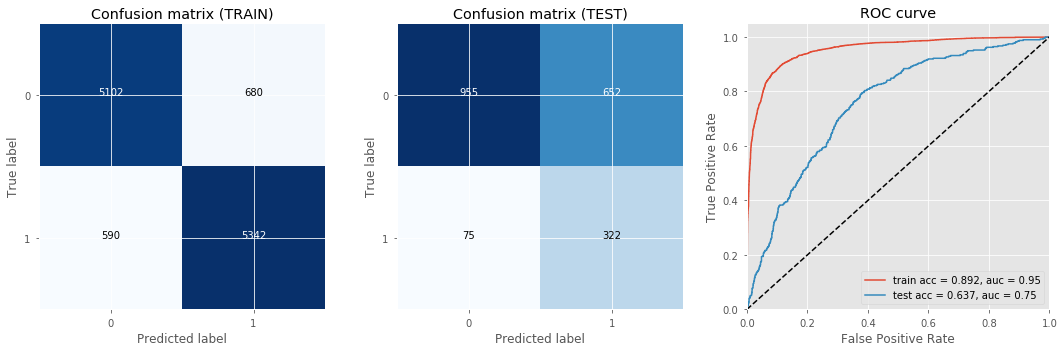

In [76]:
best_threshold,best_f1_score = best_threshold_f1_score(regr,X_resample,y_resample)
test_f1 = test_f1_score(regr,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(regr,best_threshold,X_resample,X_test,y_resample,y_test)

### SVM

In [80]:
from sklearn import svm
sm = svm.SVC(kernel='rbf', C=10,probability=True)
sm.fit(X_resample, y_resample)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

('test f1 score:', 0.47611827141774066, 'train f1 score:', 0.980271692042356)


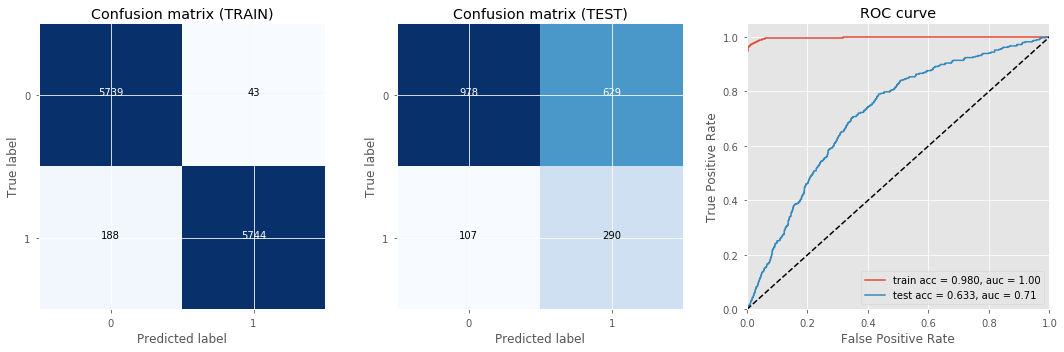

In [81]:
best_threshold,best_f1_score = best_threshold_f1_score(sm,X_resample,y_resample)
test_f1 = test_f1_score(sm,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(sm,best_threshold,X_resample,X_test,y_resample,y_test)

#### Random Forest 
bootstrap aggregating ensamble of decision trees

In [82]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
rf = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,max_features = 'log2',n_jobs=4,criterion='gini')
rf.fit(X_resample, y_resample)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

('test f1 score:', 0.47684130599848135, 'train f1 score:', 0.9958527334136364)


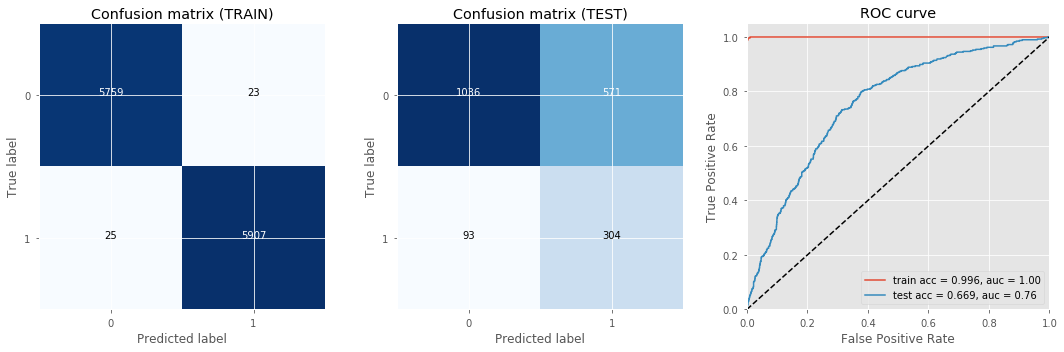

In [83]:
best_threshold,best_f1_score = best_threshold_f1_score(rf,X_resample,y_resample)
test_f1 = test_f1_score(rf,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(rf,best_threshold,X_resample,X_test,y_resample,y_test)

### GradientBoostingClassifier

In [84]:

from sklearn.ensemble import GradientBoostingClassifier
gbdt=GradientBoostingClassifier(
  loss='deviance'
, learning_rate=0.1
, n_estimators=500
, subsample=1
, min_samples_split=2
, min_samples_leaf=1
, max_depth=3
, init=None
, random_state=None
, max_features='log2'
, verbose=0
, max_leaf_nodes=None
, warm_start=False)

gbdt.fit(X_resample,y_resample)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1, verbose=0,
              warm_start=False)

('test f1 score:', 0.471976401179941, 'train f1 score:', 0.9670476514398978)


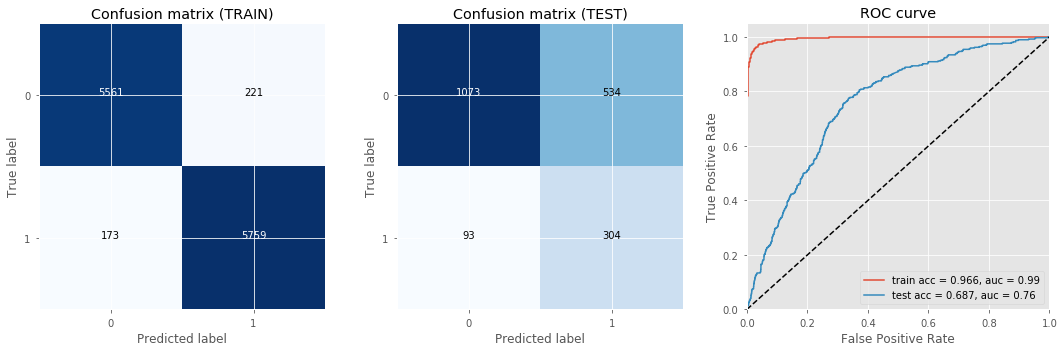

In [85]:
best_threshold,best_f1_score = best_threshold_f1_score(gbdt,X_resample,y_resample)
test_f1 = test_f1_score(gbdt,best_threshold,X_test,y_test)
print('test f1 score:',test_f1,'train f1 score:',best_f1_score)
result_analyse(gbdt,best_threshold,X_resample,X_test,y_resample,y_test)

### Deep Neural Network

117

In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SReLU
from keras.callbacks import BaseLogger, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve,f1_score
import os

# Reproducible random seed
seed = 1

# Create the output directories, if they don't exist
try:
    os.makedirs("logs")
except OSError:
    if not os.path.isdir("logs"):
        raise

try:
    os.makedirs("figs")
except OSError:
    if not os.path.isdir("figs"):
        raise


X = X_resample
Y = y_resample

# Estimate class weights since the dataset is unbalanced
class_weights = dict(zip([0, 1], compute_class_weight('balanced', [0, 1], Y)))

# Create train/test indices to split data in train/test sets
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


# Define a model generator
def generate_model():
    _model = Sequential()
    _model.add(Dense(22, input_dim=X_resample.shape[1]))
    _model.add(SReLU())
    _model.add(Dropout(0.2))
    _model.add(Dense(1, activation='sigmoid'))
    _model.compile(loss='binary_crossentropy', optimizer='adam')
    return _model


# Storage
k = 0
predictions = np.empty([len(Y), kfold.n_splits])
for train, test in kfold.split(X, Y):
    # Define model
    model = generate_model()
    # Fit the model
    history = model.fit(X[train], Y[train],
                        batch_size=1200,
                        nb_epoch=5,
                        verbose=1,
                        shuffle=True,
                        validation_data=(X[test], Y[test]),
                        class_weight=class_weights)
                        #callbacks=[baselogger, earlystop, reduce_lr])
    # Store the predicted probabilities and iterate k
    predictions[train, k] = model.predict_proba(X[train]).flatten()
    k += 1

# Average the model predictions
yhat = np.nanmean(predictions, axis=1).round().astype(int)

# Performance
print(classification_report(Y, yhat))
print(pd.crosstab(Y, yhat.flatten(), rownames=['Truth'], colnames=['Predictions']))

fpr, tpr, thresholds = roc_curve(Y, yhat)
precision, recall, thresholds = precision_recall_curve(Y, yhat)
f1 = f1_score(Y, yhat)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("figs/ROC.png")

plt.clf()
plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig("figs/precision-recall.png")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10,shuffle=True).split(X_train,y_train)

forest = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,
                                max_features = 'log2',n_jobs=4,criterion='gini')

scores = []
for k, (train, test) in enumerate(kfold):
    X_train_train,y_train_train = data_resample(X_train[train],y_train[train])
    forest.fit(X_train_train,y_train_train)
    y_test_pred = forest.predict(X_train[test])
    score = f1_score(y_train[test],y_test_pred)
    scores.append(score)
    

In [ ]:
x_num_f1 = {}
for x_num in range(20,150):

    indices = np.argsort(importances)[x_num:]

    X_train1 = X_train[:,indices]
    verify_X_test_prep1 = verify_X_test_prep[:,indices]
    rf = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,max_features = 'log2',n_jobs=4,criterion='gini')
    rf.fit(X_train1,y_train)
    
    best_f1_threshold,f1 = f1_score_set(rf,verify_X_test_prep1,real_y)
    print x_num,f1
    x_num_f1[x_num] = f1

In [55]:
indices = np.argsort(importances)[199-126:]

X_train1 = X_train[:,indices]
verify_X_test_prep1 = verify_X_test_prep[:,indices]


In [250]:
X_train1.shape

(10018, 28)

In [73]:
best_f1_threshold,f1 = f1_score_set(gbdt,verify_X_test_prep1,real_y)
print best_f1_threshold,f1

0.20202020202020204 0.5192927441472321


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.323
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)

plot_cm(ax[0],  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax[1],  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

### 预测测试集

In [16]:
threshold = best_f1_threshold
verify_y_test_pred = rf.predict_proba(verify_X_test_prep1)[:,1]
user_id = verify_sample.loc[:,['user_id']]
y_prediction  = (verify_y_test_pred > threshold).astype(int)
predict_result = pd.DataFrame(y_prediction,columns=['y_prediction'])
predict_result = user_id.join(predict_result)
p_y = predict_result['y_prediction'].values
real_y = test_result['y'].values

In [30]:
# 预测结果的f1值
score = f1_score(real_y, p_y)
print score

0.49903288201160545
